## Elementos finitos linear 1D

## Montar a matrix de massa

In [21]:
using Jacobi

## Funções

In [22]:
remap(x,a,b) = ((1-x)*a + (1+x)*b)/2

remap (generic function with 1 method)

In [23]:
function ψj(p,E,Q)
    if(p == 1)
     return  (1-E)/2
        elseif(p == 2)
     return  (1+E)/2
    else
     return  (1-E)*(1+E)/4 .* jacobi(E, p-3, 1, 1)
    end
end 

ψj (generic function with 1 method)

In [24]:
function  ϕ_matrix(ψj,Q,M)
    ϕ = zeros(Q,M)
    ξ = zglj(Q)
    for i in 1:M
        for j in 1:Q
            ϕ[j,i] = ψj(i,ξ[j],M)
        end
    end
  return ϕ
end

ϕ_matrix (generic function with 1 method)

In [25]:
function  ϕ_matrix_interp(ψj,Q,M)
    ϕ = zeros(Q,M)
    ξ = linspace(-1,1,Q)
    for i in 1:M
        for j in 1:Q
            ϕ[j,i] = ψj(i,ξ[j],M)
        end
    end
  return ϕ
end

ϕ_matrix_interp (generic function with 1 method)

In [26]:
function Me_matrix(ϕ,w,M,Q,a,b)
    L = zeros(M,M)
    jac = (b-a)/2
    for i in 1:M
        for j in 1:M
           m= 0.0
            for q in 1:Q
                m = m + ϕ[q,i]*ϕ[q,j]*w[q]*jac
            end
            L[i,j] = m
        end
    end
    return L
end

Me_matrix (generic function with 1 method)

### $ϕ$ e  matriz de massa

In [27]:
Nel = 50
I = 5
nb = Nel + 1
ni = (I-2)
Q = I+2

#indices locais
ib = collect(1:2)
ii = collect(3:I)

#limites
a = -1; 
b = 1;

z = zglj(Q)
w = wglj(z)
ϕ = ϕ_matrix(ψj,Q,I);
xn = [linspace(a,b,Nel+1);];
X = zeros(Q,Nel)
remap(x,a,b) = ((1-x)*a + (1+x)*b)/2
for e in 1:Nel
    X[:,e] = [remap(x,xn[e],xn[e+1]) for x in z]
end
X

7x50 Array{Float64,2}:
 -1.0       -0.96      -0.92      -0.88      …  0.88      0.92      0.96    
 -0.996604  -0.956604  -0.916604  -0.876604     0.883396  0.923396  0.963396
 -0.989377  -0.949377  -0.909377  -0.869377     0.890623  0.930623  0.970623
 -0.98      -0.94      -0.9       -0.86         0.9       0.94      0.98    
 -0.970623  -0.930623  -0.890623  -0.850623     0.909377  0.949377  0.989377
 -0.963396  -0.923396  -0.883396  -0.843396  …  0.916604  0.956604  0.996604
 -0.96      -0.92      -0.88      -0.84         0.92      0.96      1.0     

In [28]:

dof_map = zeros(Int, 2, Nel)
for i = 1:Nel
    dof_map[1,i] = i
    dof_map[2,i] = i+1
end
dof_map

2x50 Array{Int64,2}:
 1  2  3  4  5  6  7  8   9  10  11  …  42  43  44  45  46  47  48  49  50
 2  3  4  5  6  7  8  9  10  11  12     43  44  45  46  47  48  49  50  51

In [29]:

using Base.LinAlg.BLAS.gemm!
using Base.LinAlg.BLAS.gemv!
using Base.LinAlg.LAPACK.potrf!
using Base.LinAlg.LAPACK.potrs!

### $ A_{bb}^* = (A_{bb} - A_{bi} A_{ii}^{-1} A_{ib})  $

In [30]:
Abb = zeros(Nel+1,Nel+1)
M = Vector{Array{Float64,2}}(Nel)
Mii = Vector{Array{Float64,2}}(Nel)
for e in 1:Nel
    Me  = Me_matrix(ϕ,w,I,Q,a,b)
    Mbb = Me[ib,ib]
    Mbi = Me[ib,ii]
    Mib = Me[ii,ib]
    Mii[e] = Me[ii,ii]
    
    potrf!('L',Mii[e]); #Mii^-1
    M[e] = copy(Mib)
    potrs!('L',Mii[e],M[e]) # M = Mii^-1 * Mbi
    gemm!('T', 'N', -1.0, M[e], Mib, 1.0, Mbb) # Mbb = -1*M*Mib + Mbb
    
    for i in 1:2
        ig = dof_map[i,e]
        for j in 1:2
            jg = dof_map[j,e]
            Abb[ig,jg] += Mbb[i,j]
        end
    end
end

potrf!('L',Abb);


In [31]:
Abb

51x51 Array{Float64,2}:
  0.288675  -0.0166667   0.0        …   0.0         0.0         0.0      
 -0.057735   0.404145   -0.0166667      0.0         0.0         0.0      
  0.0       -0.0412393   0.40616        0.0         0.0         0.0      
  0.0        0.0        -0.0410347      0.0         0.0         0.0      
  0.0        0.0         0.0            0.0         0.0         0.0      
  0.0        0.0         0.0        …   0.0         0.0         0.0      
  0.0        0.0         0.0            0.0         0.0         0.0      
  0.0        0.0         0.0            0.0         0.0         0.0      
  0.0        0.0         0.0            0.0         0.0         0.0      
  0.0        0.0         0.0            0.0         0.0         0.0      
  0.0        0.0         0.0        …   0.0         0.0         0.0      
  0.0        0.0         0.0            0.0         0.0         0.0      
  0.0        0.0         0.0            0.0         0.0         0.0      
  ⋮           

## RHS

In [32]:
fun(x) = cos(2*pi*x)
#calcula F
Fe = zeros(I,Nel)
for e = 1:Nel
    jac = (xn[e+1] - xn[e] )/2
    for i in 1:I
        temp = 0.0
        for q in 1:Q
            temp += fun(X[q,e])* ϕ[q,i] * w[q] * jac
        end
        Fe[i,e] = temp
    end
end
Fe

5x50 Array{Float64,2}:
  0.0198949    0.0188545     0.0166294    …   0.0182387     0.0196853 
  0.0196853    0.0182387     0.0156461        0.0188545     0.0198949 
  0.00660366   0.00618873    0.00538493       0.00618873    0.00660366
 -4.19522e-5  -0.000123221  -0.000196747      0.000123221   4.19522e-5
 -8.94463e-6  -8.38261e-6   -7.29387e-6      -8.38261e-6   -8.94463e-6

In [33]:
B = Fe[:,1]
Bb = B[ib]
Bi = B[ii];

### $f_b^* =f_b - A_{bi} A_{ii}^{-1} f_i$

In [34]:
Fb = zeros(nb)

for e in 1:Nel
    fe  = Fe[:,e]
    fb  = fe[ib]
    fi  = fe[ii]
    gemv!('T',-1.0,M[e],fi, 1.0, fb) #fbb = -1*M^T*fi + fb

    for i in 1:2
        ig = dof_map[i,e]
        Fb[ig] += fb[i]
    end
end
Fb

51-element Array{Float64,1}:
  0.00134381 
  0.00260317 
  0.00235517 
  0.00195918 
  0.00144009 
  0.000830518
  0.000168757
 -0.000503608
 -0.00114433 
 -0.00171315 
 -0.00217432 
 -0.00249888 
 -0.00266642 
  ⋮          
 -0.00249888 
 -0.00217432 
 -0.00171315 
 -0.00114433 
 -0.000503608
  0.000168757
  0.000830518
  0.00144009 
  0.00195918 
  0.00235517 
  0.00260317 
  0.00134381 

# Solve   $A^*_{bb}\ u_b =\ f^*_b$

In [35]:
Abb

51x51 Array{Float64,2}:
  0.288675  -0.0166667   0.0        …   0.0         0.0         0.0      
 -0.057735   0.404145   -0.0166667      0.0         0.0         0.0      
  0.0       -0.0412393   0.40616        0.0         0.0         0.0      
  0.0        0.0        -0.0410347      0.0         0.0         0.0      
  0.0        0.0         0.0            0.0         0.0         0.0      
  0.0        0.0         0.0        …   0.0         0.0         0.0      
  0.0        0.0         0.0            0.0         0.0         0.0      
  0.0        0.0         0.0            0.0         0.0         0.0      
  0.0        0.0         0.0            0.0         0.0         0.0      
  0.0        0.0         0.0            0.0         0.0         0.0      
  0.0        0.0         0.0        …   0.0         0.0         0.0      
  0.0        0.0         0.0            0.0         0.0         0.0      
  0.0        0.0         0.0            0.0         0.0         0.0      
  ⋮           

In [36]:
potrs!('L',Abb,Fb)
Ub = Fb


51-element Array{Float64,1}:
  0.02      
  0.0193717 
  0.0175261 
  0.0145794 
  0.0107165 
  0.00618034
  0.00125581
 -0.00374763
 -0.00851559
 -0.0127485 
 -0.0161803 
 -0.0185955 
 -0.0198423 
  ⋮         
 -0.0185955 
 -0.0161803 
 -0.0127485 
 -0.00851559
 -0.00374763
  0.00125581
  0.00618034
  0.0107165 
  0.0145794 
  0.0175261 
  0.0193717 
  0.02      

### $u_i = A_{ii}^{-1}f_i - A_{ii}^{-1} A_{bi}^t u_b$

In [37]:
U = zeros(I,Nel)
for e in 1:Nel
    ub  = Ub[vec(dof_map[:,e])]
    fe  = Fe[:,e]
    fi  = fe[ii]

    potrs!('L',Mii[e],fi)
    gemv!('N',-1.0,M[e],ub,1.0,fi) #fi = -1*M*ub + fi
    
    U[ib,e] = ub
    U[ii,e] = fi
end
U

5x50 Array{Float64,2}:
  0.02          0.0193717     0.0175261    …   0.0175261     0.0193717  
  0.0193717     0.0175261     0.0145794        0.0193717     0.02       
  0.000625685   0.000586371   0.000510213      0.000586371   0.000625685
 -1.65634e-6   -4.86494e-6   -7.76786e-6       4.86494e-6    1.65634e-6 
 -2.19413e-7   -2.05626e-7   -1.7892e-7       -2.05626e-7   -2.19413e-7 

In [38]:
Uh = zeros(Q,Nel)
for e in 1:Nel
    Uh[:,e] = ϕ*U[:,e]
end
Uh

7x50 Array{Float64,2}:
 0.02       0.0193717  0.0175261  …  0.0145794  0.0175261  0.0193717
 0.0199954  0.0192611  0.0173166     0.0148681  0.0177277  0.0194734
 0.0199555  0.0189968  0.0168445     0.0154601  0.0181297  0.0196603
 0.0198423  0.0185955  0.0161803     0.0161803  0.0185955  0.0198423
 0.0196603  0.0181297  0.0154601     0.0168445  0.0189968  0.0199555
 0.0194734  0.0177277  0.0148681  …  0.0173166  0.0192611  0.0199954
 0.0193717  0.0175261  0.0145794     0.0175261  0.0193717  0.02     

In [39]:
using PyPlot

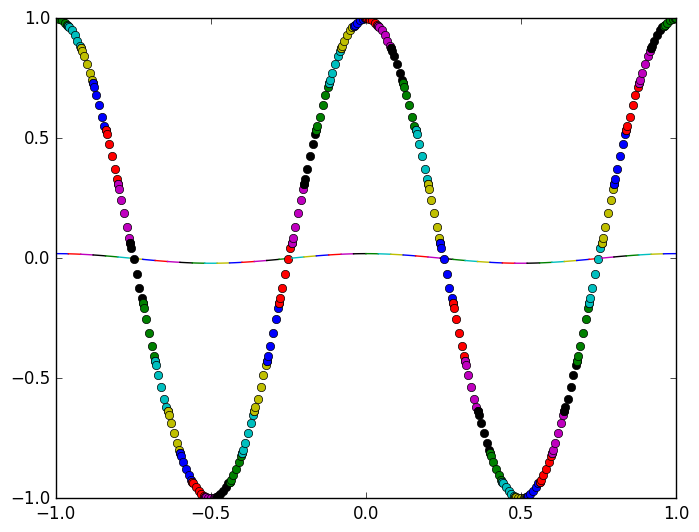

In [40]:
for e in 1:Nel
    plot(X[:,e],Uh[:,e])
    plot(X[:,e],fun(X[:,e]),"o")
    #legend()
end
